# Capstone Project - The Battle of the Neighborhoods (Week 2)

## Introduction: Business Problem 
This project aims to select the safest borough in London based on the total crimes, explore the neighborhoods of that borough to find the 10 most common venues in each neighborhood and finally cluster the neighborhoods using k-mean clustering.

This report will be targeted to people who are looking to relocate to London. In order to finalize a neighborhood to hunt for an apartment, safety is considered as a top concern when moving to a new place. If you do not feel safe in your own home, you are not going to be able to enjoy living there. The crime statistics will provide an insight into this issue.

We will focus on the safest borough and explore its neighborhoods and the 10 most common venues in each neighborhood so that the best neighborhood suited to an individual's needs can be selected.

## Data 
Based on definition of our problem, factors that will influence our decision are:

- The total number of crimes committed in each of the borough during the last year.
- The most common venues in each of the neighborhood in the safest borough selected.
We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:

- Part 1 : Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016. A dataset consisting of the crime statistics of each borough in London obtained from Kaggle
- Part 2 : Scraping additional information of the different Boroughs in London from a Wikipedia page. More information regarding the boroughs of London is scraped using the Beautifulsoup library
- Part 3 : Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates. Co-ordinate of neighborhood will be obtained using Google Maps API geocoding

### Neighborhood Candidates
### Part 1: Preprocessing a real world data set from Kaggle showing the London Crimes from 2008 to 2016
#### London Crime Data

About this file

- lsoa_code : code for Lower Super Output Area in Greater London
- borough : Common name for London borough
- major_category : High level categorization of crime
- minor_category : Low level categorization of crime within major category
- value : monthly reported count of categorical crime in given borough
- year : Year of reported counts, 2008-2016
- month : Month of reported counts, 1-12

Data set URL : https://www.kaggle.com/jboysen/london-crime

In [1]:
# Import necessary libraries
import sys
!{sys.executable} -m pip install geocoder
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install wget
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install BeautifulSoup4
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install lxml

# library to handle requests
import requests

# library for data analsysis
import pandas as pd

# library to handle data in a vectorized manner
import numpy as np

# library for random number generation
import random

# library for web scrapping
from bs4 import BeautifulSoup

#!conda install -c conda-forge geocoder --yes
import geocoder

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

Folium installed
Libraries imported.


In [2]:
# Define foursquare credentials and version
CLIENT_ID = 'OASF14U2ZMVH2ZCCIRXXCIMGDLAWMVNS3UFVHVDOHCQPYKD1' # your Foursquare ID
CLIENT_SECRET = 'XDMHJM02RBCU4OKXOHB3VORN1BSLRDOAHYU4P3MEHLHDU1WK' # your Foursquare Secret

VERSION = '20180604'
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OASF14U2ZMVH2ZCCIRXXCIMGDLAWMVNS3UFVHVDOHCQPYKD1
CLIENT_SECRET:XDMHJM02RBCU4OKXOHB3VORN1BSLRDOAHYU4P3MEHLHDU1WK


In [3]:
# Read in the data 
df = pd.read_csv("london_crime_by_lsoa.csv")

# View the top rows of the dataset
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01001116,Croydon,Burglary,Burglary in Other Buildings,0.0,2016.0,11.0
1,E01001646,Greenwich,Violence Against the Person,Other violence,0.0,2016.0,11.0
2,E01000677,Bromley,Violence Against the Person,Other violence,0.0,2015.0,5.0
3,E01003774,Redbridge,Burglary,Burglary in Other Buildings,0.0,2016.0,3.0
4,E01004563,Wandsworth,Robbery,Personal Property,0.0,2008.0,6.0


In [4]:
# Taking only the most recent year (2016) and dropping the rest
df.drop(df.index[df['year'] != 2016], inplace = True)

# Removing all the entires where crime values are null  
df = df[df.value != 0]

# Reset the index and dropping the previous index
df = df.reset_index(drop=True)

In [5]:

# Shape of the data frame
df.shape

(12815, 7)

In [6]:
# View the top of the dataset 
df.head()

,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


In [7]:
df.columns = ['LSOA_Code', 'Borough','Major_Category','Minor_Category','No_of_Crimes','Year','Month']
df.head()

,LSOA_Code,Borough,Major_Category,Minor_Category,No_of_Crimes,Year,Month
0,E01004177,Sutton,Theft and Handling,Theft/Taking of Pedal Cycle,1.0,2016.0,8.0
1,E01000733,Bromley,Criminal Damage,Criminal Damage To Motor Vehicle,1.0,2016.0,4.0
2,E01003989,Southwark,Theft and Handling,Theft From Shops,4.0,2016.0,8.0
3,E01002276,Havering,Burglary,Burglary in a Dwelling,1.0,2016.0,8.0
4,E01003674,Redbridge,Drugs,Possession Of Drugs,2.0,2016.0,11.0


In [8]:
# View the information of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12815 entries, 0 to 12814
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   LSOA_Code       12815 non-null  object 
 1   Borough         12815 non-null  object 
 2   Major_Category  12815 non-null  object 
 3   Minor_Category  12815 non-null  object 
 4   No_of_Crimes    12815 non-null  float64
 5   Year            12815 non-null  float64
 6   Month           12815 non-null  float64
dtypes: float64(3), object(4)
memory usage: 700.9+ KB


In [9]:
df['Borough'].value_counts()

Lambeth                   559
Southwark                 555
Croydon                   547
Newham                    523
Tower Hamlets             500
Brent                     491
Ealing                    488
Hackney                   458
Haringey                  457
Barnet                    454
Wandsworth                452
Enfield                   442
Waltham Forest            435
Lewisham                  433
Westminster               418
Greenwich                 418
Islington                 418
Camden                    417
Hillingdon                410
Bromley                   396
Hounslow                  385
Redbridge                 382
Hammersmith and Fulham    338
Barking and Dagenham      338
Havering                  336
Kensington and Chelsea    328
Harrow                    279
Merton                    272
Bexley                    261
Richmond upon Thames      230
Sutton                    217
Kingston upon Thames      173
City of London              5
Name: Boro

In [10]:
df['Major_Category'].value_counts()

Theft and Handling             4164
Violence Against the Person    4089
Criminal Damage                1604
Burglary                       1411
Drugs                           703
Robbery                         461
Other Notifiable Offences       383
Name: Major_Category, dtype: int64

In [11]:
London_crime = pd.pivot_table(df,values=['No_of_Crimes'],
                               index=['Borough'],
                               columns=['Major_Category'],
                               aggfunc=np.sum,fill_value=0)
London_crime.head()

No_of_Crimes                        \
Major_Category           Burglary Criminal Damage Drugs   
Borough                                                   
Barking and Dagenham           50              81    28   
Barnet                        108              70    24   
Bexley                         36              65    26   
Brent                          78              70    51   
Bromley                        62              65    16   

                                                                           \
Major_Category       Other Notifiable Offences Robbery Theft and Handling   
Borough                                                                     
Barking and Dagenham                        23      11                187   
Barnet                                      19      14                275   
Bexley                                       6       4                149   
Brent                                       18      20                290   
Bromley                                     17       9                243   

                                                  
Major_Category       Violence Against the Person  
Borough                                           
Barking and Dagenham                         184  
Barnet                                       227  
Bexley                                       137  
Brent                                        305  
Bromley                                      226

In [12]:
# Reset the index
London_crime.reset_index(inplace = True)

# Total crimes per Borough
London_crime['Total'] = London_crime.sum(axis=1)
London_crime.head()

Borough No_of_Crimes                        \
Major_Category                           Burglary Criminal Damage Drugs   
0               Barking and Dagenham           50              81    28   
1                             Barnet          108              70    24   
2                             Bexley           36              65    26   
3                              Brent           78              70    51   
4                            Bromley           62              65    16   

                                                                     \
Major_Category Other Notifiable Offences Robbery Theft and Handling   
0                                     23      11                187   
1                                     19      14                275   
2                                      6       4                149   
3                                     18      20                290   
4                                     17       9                243   

                                           Total  
Major_Category Violence Against the Person        
0                                      184   564  
1                                      227   737  
2                                      137   423  
3                                      305   832  
4                                      226   638

In [13]:
London_crime.columns = London_crime.columns.map(''.join)
London_crime.head()


,Borough,No_of_CrimesBurglary,No_of_CrimesCriminal Damage,No_of_CrimesDrugs,No_of_CrimesOther Notifiable Offences,No_of_CrimesRobbery,No_of_CrimesTheft and Handling,No_of_CrimesViolence Against the Person,Total
0,Barking and Dagenham,50,81,28,23,11,187,184,564
1,Barnet,108,70,24,19,14,275,227,737
2,Bexley,36,65,26,6,4,149,137,423
3,Brent,78,70,51,18,20,290,305,832
4,Bromley,62,65,16,17,9,243,226,638



Removing the multi index so that it will be easier to merge.

In [14]:

# Renaming the columns
London_crime.columns = ['Borough','Burglary', 'Criminal Damage','Drugs','Other Notifiable Offences',
                        'Robbery','Theft and Handling','Violence Against the Person','Total']
London_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,50,81,28,23,11,187,184,564
1,Barnet,108,70,24,19,14,275,227,737
2,Bexley,36,65,26,6,4,149,137,423
3,Brent,78,70,51,18,20,290,305,832
4,Bromley,62,65,16,17,9,243,226,638


In [16]:
# Shape of the data set 
London_crime.shape

(33, 9)

Part 2 : Scraping additional information of the different Boroughs in London from a Wikipedia page
Using Beautiful soup to scrap the latitude and longitude of the boroughs in London.

URL : https://en.wikipedia.org/wiki/List_of_London_boroughs

In [17]:
# getting data from internet
wikipedia_link='https://en.wikipedia.org/wiki/List_of_London_boroughs'
raw_wikipedia_page=requests.get(wikipedia_link).text

# using beautiful soup to parse the HTML/XML codes.
soup = BeautifulSoup(raw_wikipedia_page, 'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of London boroughs - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"XqcRGgpAICMAACuTa54AAAEK","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_London_boroughs","wgTitle":"List of London boroughs","wgCurRevisionId":953518321,"wgRevisionId":953518321,"wgArticleId":28092685,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2015","Use British English from August 2015","Lists of coordinates","Geographic coordinate lists","Article

In [18]:
# extracting the raw table inside that webpage
table = soup.find_all('table', {'class':'wikitable sortable'})
print(table)

[<table class="wikitable sortable" style="font-size:100%" width="100%">
<tbody><tr>
<th>Borough
</th>
<th>Inner
</th>
<th>Status
</th>
<th>Local authority
</th>
<th>Political control
</th>
<th>Headquarters
</th>
<th>Area (sq mi)
</th>
<th>Population (2013 est)<sup class="reference" id="cite_ref-1"><a href="#cite_note-1">[1]</a></sup>
</th>
<th>Co-ordinates
</th>
<th><span style="background:#67BCD3"> Nr. in map </span>
</th></tr>
<tr>
<td><a href="/wiki/London_Borough_of_Barking_and_Dagenham" title="London Borough of Barking and Dagenham">Barking and Dagenham</a> <sup class="reference" id="cite_ref-2"><a href="#cite_note-2">[note 1]</a></sup>
</td>
<td>
</td>
<td>
</td>
<td><a href="/wiki/Barking_and_Dagenham_London_Borough_Council" title="Barking and Dagenham London Borough Council">Barking and Dagenham London Borough Council</a>
</td>
<td><a href="/wiki/Labour_Party_(UK)" title="Labour Party (UK)">Labour</a>
</td>
<td><a href="/wiki/Barking_Town_Hall" title="Barking Town Hall">Town Ha

In [19]:
London_table = pd.read_html(str(table[0]), index_col=None, header=0)[0]
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [20]:
# Read in the second table 
London_table1 = pd.read_html(str(table[1]), index_col=None, header=0)[0]

# Rename the columns to match the previous table to append the tables.

London_table1.columns = ['Borough','Inner','Status','Local authority','Political control',
                         'Headquarters','Area (sq mi)','Population (2013 est)[1]','Co-ordinates','Nr. in map']

# View the table
London_table1

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1



The second table on the site contains the addition Borough i.e. City of London.

In [21]:
# A continuous index value will be maintained 
# across the rows in the new appended data frame. 

London_table = London_table.append(London_table1, ignore_index = True) 
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


Append the data frame together.

In [22]:
London_table.tail()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
28,Tower Hamlets,NaN,NaN,Tower Hamlets London Borough Council,Labour,"Town Hall, Mulberry Place, 5 Clove Crescent",7.63,272890,51°30′36″N 0°00′21″W﻿ / ﻿51.5099°N 0.0059°W,8
29,Waltham Forest,NaN,NaN,Waltham Forest London Borough Council,Labour,"Waltham Forest Town Hall, Forest Road",14.99,265797,51°35′27″N 0°00′48″W﻿ / ﻿51.5908°N 0.0134°W,28
30,Wandsworth,NaN,NaN,Wandsworth London Borough Council,Conservative,"The Town Hall, Wandsworth High Street",13.23,310516,51°27′24″N 0°11′28″W﻿ / ﻿51.4567°N 0.1910°W,5
31,Westminster,NaN,City,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,2
32,City of London,([note 5],Sui generis;City;Ceremonial county,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,1



Check if the last row was appended correctly.

In [23]:
London_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Borough                   33 non-null     object 
 1   Inner                     4 non-null      object 
 2   Status                    5 non-null      object 
 3   Local authority           33 non-null     object 
 4   Political control         33 non-null     object 
 5   Headquarters              33 non-null     object 
 6   Area (sq mi)              33 non-null     float64
 7   Population (2013 est)[1]  33 non-null     int64  
 8   Co-ordinates              33 non-null     object 
 9   Nr. in map                33 non-null     int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.7+ KB


In [24]:

London_table = London_table.replace('note 1','', regex=True) 
London_table = London_table.replace('note 2','', regex=True) 
London_table = London_table.replace('note 3','', regex=True) 
London_table = London_table.replace('note 4','', regex=True) 
London_table = London_table.replace('note 5','', regex=True) 

# View the top of the data set
London_table.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20



Removing Unnecessary string in the Data set.

In [25]:
type(London_table)

pandas.core.frame.DataFrame

Check the type of the newly created table.

In [26]:
# Shape of the data frame
London_table.shape

(33, 10)

In [27]:
set(df.Borough) - set(London_table.Borough)

{'Barking and Dagenham', 'Greenwich', 'Hammersmith and Fulham'}

Check if the Borough in both the data frames match.

These 3 Boroughs don't match because of the unnecessary symbols present "[]".

In [28]:
print("The index of first borough is",London_table.index[London_table['Borough'] == 'Barking and Dagenham []'].tolist())
print("The index of second borough is",London_table.index[London_table['Borough'] == 'Greenwich []'].tolist())
print("The index of third borough is",London_table.index[London_table['Borough'] == 'Hammersmith and Fulham []'].tolist())

The index of first borough is [0]
The index of second borough is [9]
The index of third borough is [11]



Find the index of the Boroughs that didn't match.

In [29]:
London_table.iloc[0,0] = 'Barking and Dagenham'
London_table.iloc[9,0] = 'Greenwich'
London_table.iloc[11,0] = 'Hammersmith and Fulham'

Changing the Borough names to match the other data frame.

In [30]:
set(df.Borough) - set(London_table.Borough)

set()

Check if the Borough names in both data sets match.

The Borough names in both data frames match.

In [31]:
Ld_crime = pd.merge(London_crime, London_table, on='Borough')
Ld_crime.head()

,Borough,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham,50,81,28,23,11,187,184,564,NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,108,70,24,19,14,275,227,737,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,36,65,26,6,4,149,137,423,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,78,70,51,18,20,290,305,832,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,62,65,16,17,9,243,226,638,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [32]:
Ld_crime.shape

(33, 18)

In [33]:
set(df.Borough) - set(Ld_crime.Borough)

set()

In [34]:
# List of Column names of the data frame 
list(Ld_crime)

['Borough',
 'Burglary',
 'Criminal Damage',
 'Drugs',
 'Other Notifiable Offences',
 'Robbery',
 'Theft and Handling',
 'Violence Against the Person',
 'Total',
 'Inner',
 'Status',
 'Local authority',
 'Political control',
 'Headquarters',
 'Area (sq mi)',
 'Population (2013 est)[1]',
 'Co-ordinates',
 'Nr. in map']

Rearranging the Columns.

In [35]:
columnsTitles = ['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]',
                 'Inner','Status',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total','Co-ordinates']

Ld_crime = Ld_crime.reindex(columns=columnsTitles)

Ld_crime = Ld_crime[['Borough','Local authority','Political control','Headquarters',
                 'Area (sq mi)','Population (2013 est)[1]','Co-ordinates',
                 'Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person','Total']]

Ld_crime.head()

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
0,Barking and Dagenham,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,50,81,28,23,11,187,184,564
1,Barnet,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,108,70,24,19,14,275,227,737
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,36,65,26,6,4,149,137,423
3,Brent,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,78,70,51,18,20,290,305,832
4,Bromley,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,62,65,16,17,9,243,226,638


## Methodology

The methodology in this project consists of two parts :

- Exploratory Data Analysis: Visualize the crime rates in the London boroughs to identity the safest borough and extract the neighborhoods in that borough to find the 10 most common venues in each neighborhood.
- Modeling: To help people find similar neighborhoods in the safest borough we will be clustering similar neighborhoods using K-means clustering which is a form of unsupervised machine learning algorithm that clusters data based on predefined cluster size. We will use a cluster size of 5 for this project that will cluster the 15 neighborhoods into 5 clusters. The reason to conduct a K- means clustering is to cluster neighborhoods with similar venues together so that people can shortlist the area of their interests based on the venues/amenities around each neighborhood.

### Exploratory Data Analysis¶

In [36]:
London_crime.describe()

,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,65.878788,64.787879,40.878788,15.242424,19.939394,292.060606,230.363636,729.151515
std,25.140552,22.740049,26.263993,7.717797,13.939466,138.738049,87.472788,288.454949
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,5.000000
25%,50.000000,48.000000,24.000000,9.000000,8.000000,192.000000,184.000000,573.000000
50%,67.000000,70.000000,34.000000,17.000000,20.000000,284.000000,229.000000,732.000000
75%,81.000000,79.000000,55.000000,19.000000,30.000000,371.000000,281.000000,871.000000
max,113.000000,119.000000,107.000000,36.000000,55.000000,746.000000,439.000000,1547.000000


Descriptive statistics of the data.

In [37]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

Matplotlib version:  3.1.1


In [38]:
Ld_crime.columns = list(map(str, Ld_crime.columns))

# let's check the column labels types now
all(isinstance(column, str) for column in Ld_crime.columns)

True

Check if the column names are strings.

In [39]:
Ld_crime.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df_top5 = Ld_crime.head() 
df_top5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
32,Westminster,Westminster City Council,Conservative,"Westminster City Hall, 64 Victoria Street",8.29,226841,51°29′50″N 0°08′14″W﻿ / ﻿51.4973°N 0.1372°W,86,78,107,36,55,746,439,1547
24,Newham,Newham London Borough Council,Labour,"Newham Dockside, 1000 Dockside Road",13.98,318227,51°30′28″N 0°02′49″E﻿ / ﻿51.5077°N 0.0469°E,56,69,85,22,44,536,326,1138
27,Southwark,Southwark London Borough Council,Labour,160 Tooley Street,11.14,298464,51°30′13″N 0°04′49″W﻿ / ﻿51.5035°N 0.0804°W,113,97,66,25,30,426,331,1088
21,Lambeth,Lambeth London Borough Council,Labour,"Lambeth Town Hall, Brixton Hill",10.36,314242,51°27′39″N 0°06′59″W﻿ / ﻿51.4607°N 0.1163°W,92,91,101,19,31,432,290,1056
7,Croydon,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,372752,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,64,119,44,24,28,340,354,973


Sort the total crimes in descenting order to see 5 boroughs with the highest number of crimes.

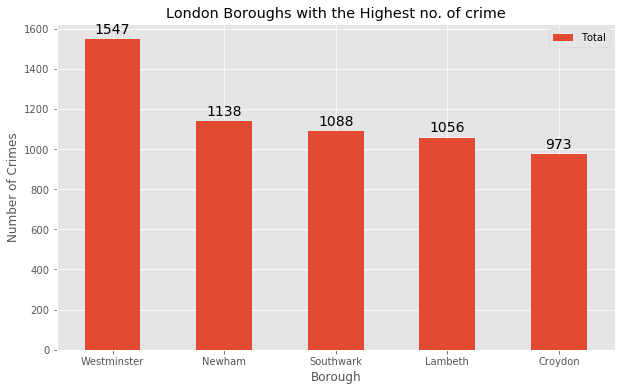

In [40]:
df_tt = df_top5[['Borough','Total']]

df_tt.set_index('Borough',inplace = True)

ax = df_tt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the Highest no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()


Visualize the five boroughs with the highest number of crimes.

In [41]:
Ld_crime.sort_values(['Total'], ascending = True, axis = 0, inplace = True )

df_bot5 = Ld_crime.head() 
df_bot5

,Borough,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Burglary,Criminal Damage,Drugs,Other Notifiable Offences,Robbery,Theft and Handling,Violence Against the Person,Total
6,City of London,Corporation of London;Inner Temple;Middle Temple,?,Guildhall,1.12,7000,51°30′56″N 0°05′32″W﻿ / ﻿51.5155°N 0.0922°W,0,0,0,0,0,4,1,5
20,Kingston upon Thames,Kingston upon Thames London Borough Council,Liberal Democrat,"Guildhall, High Street",14.38,166793,51°24′31″N 0°18′23″W﻿ / ﻿51.4085°N 0.3064°W,27,37,22,7,2,106,101,302
26,Richmond upon Thames,Richmond upon Thames London Borough Council,Liberal Democrat,"Civic Centre, 44 York Street",22.17,191365,51°26′52″N 0°19′34″W﻿ / ﻿51.4479°N 0.3260°W,41,49,5,4,1,137,98,335
28,Sutton,Sutton London Borough Council,Liberal Democrat,"Civic Offices, St Nicholas Way",16.93,195914,51°21′42″N 0°11′40″W﻿ / ﻿51.3618°N 0.1945°W,29,36,16,7,3,141,115,347
2,Bexley,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,36,65,26,6,4,149,137,423


We'll stay clear from these places.

Sort the total crimes in ascending order to see 5 boroughs with the highest number of crimes.

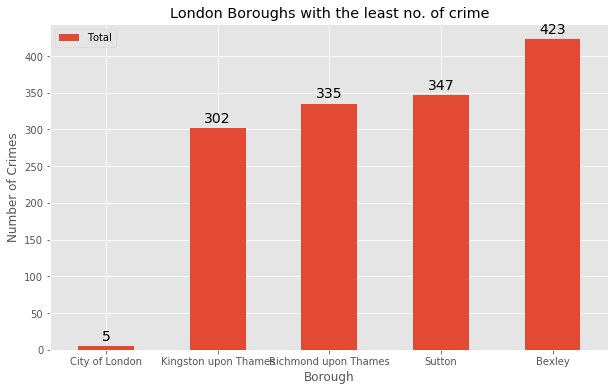

In [42]:
df_bt = df_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Visualize the five boroughs with the least number of crimes.

The borough City of London has the lowest no. of crimes recorded for the year 2016, Looking into the details of the borough:

In [43]:
df_col = df_bot5[df_bot5['Borough'] == 'City of London']
df_col = df_col[['Borough','Total','Area (sq mi)','Population (2013 est)[1]']]
df_col

,Borough,Total,Area (sq mi),Population (2013 est)[1]
6,City of London,5,1.12,7000


As per the wikipedia page, the City of London is the 33rd principal division of greater London but it is not a London borough.

URL : https://en.wikipedia.org/wiki/List_of_London_boroughs

Hence we will focus on the next borough with the least crime i.e. Kingston upon Thames

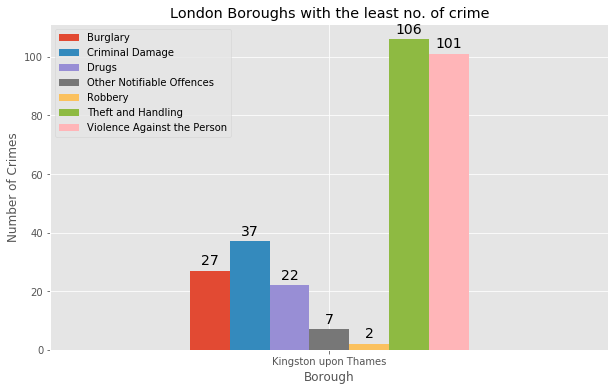

In [44]:
df_bc1 =  df_bot5[df_bot5['Borough'] == 'Kingston upon Thames']

df_bc = df_bc1[['Borough','Burglary','Criminal Damage','Drugs','Other Notifiable Offences',
                 'Robbery','Theft and Handling','Violence Against the Person']]


df_bc.set_index('Borough',inplace = True)

ax = df_bc.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Borough') # add y-label to the plot
ax.set_title('London Boroughs with the least no. of crime') # add title to the plot

# Creating a function to display the percentage.

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

Visualizing different types of crimes in the borough 'Kingston upon Thames'

We can conclude that Kingston upon Thames is the safest borough when compared to the other boroughs in London.

Part 3: Creating a new dataset of the Neighborhoods of the safest borough in London and generating their co-ordinates.
The list of Neighborhoods in the Royal Borough of Kingston upon Thames was found on a wikipedia page : https://en.wikipedia.org/wiki/List_of_districts_in_the_Royal_Borough_of_Kingston_upon_Thames

In [45]:
Neighborhood = ['Berrylands','Canbury','Chessington','Coombe','Hook','Kingston upon Thames',
'Kingston Vale','Malden Rushett','Motspur Park','New Malden','Norbiton',
'Old Malden','Seething Wells','Surbiton','Tolworth']

Borough = ['Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames','Kingston upon Thames',
          'Kingston upon Thames','Kingston upon Thames','Kingston upon Thames']

Latitude = ['','','','','','','','','','','','','','','']
Longitude = ['','','','','','','','','','','','','','','']

df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,,
1,Canbury,Kingston upon Thames,,
2,Chessington,Kingston upon Thames,,
3,Coombe,Kingston upon Thames,,
4,Hook,Kingston upon Thames,,
5,Kingston upon Thames,Kingston upon Thames,,
6,Kingston Vale,Kingston upon Thames,,
7,Malden Rushett,Kingston upon Thames,,
8,Motspur Park,Kingston upon Thames,,
9,New Malden,Kingston upon Thames,,


In [46]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{},London,United Kingdom'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)

[51.3937811, 51.41749865, 51.358336, 51.4194499, 51.3678984, 51.4096275, 51.43185, 51.3410523, 51.3909852, 51.4053347, 51.4099994, 51.382484, 51.3926421, 51.3937557, 51.3788758] [-0.2848024, -0.30555280504926163, -0.2986216, -0.2653985, -0.3071453, -0.3062621, -0.2581379, -0.3190757, -0.2488979, -0.2634066, -0.2873963, -0.2590897, -0.3143662, -0.3033105, -0.2828604]


Find the Co-ordiantes of each Neighborhood in the Kingston upon Thames Neighborhood.

In [47]:
df_neigh = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
kut_neig = pd.DataFrame(data=df_neigh, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

kut_neig

,Neighborhood,Borough,Latitude,Longitude
0,Berrylands,Kingston upon Thames,51.393781,-0.284802
1,Canbury,Kingston upon Thames,51.417499,-0.305553
2,Chessington,Kingston upon Thames,51.358336,-0.298622
3,Coombe,Kingston upon Thames,51.419450,-0.265398
4,Hook,Kingston upon Thames,51.367898,-0.307145
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262
6,Kingston Vale,Kingston upon Thames,51.431850,-0.258138
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898
9,New Malden,Kingston upon Thames,51.405335,-0.263407


In [48]:
address = 'Berrylands, London, United Kingdom'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Berrylands, London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Berrylands, London are 51.3937811, -0.2848024.


Get the co-ordinates of Berrylands, London, United Kingdom (The center neighborhood of Kingston upon Thames).

In [49]:
# create map of New York using latitude and longitude values
map_lon = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(kut_neig['Latitude'], kut_neig['Longitude'], kut_neig['Borough'], kut_neig['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

Visualize the Neighborhood of Kingston upon Thames Borough

# Modelling
- Finding all the venues within a 500 meter radius of each neighborhood.
- Perform one hot ecoding on the venues data.
- Grouping the venues by the neighborhood and calculating their mean.
- Performing a K-means clustering (Defining K = 5)

In [50]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a function to extract the venues from each Neighborhood.

In [51]:
kut_venues = getNearbyVenues(names=kut_neig['Neighborhood'],
                                   latitudes=kut_neig['Latitude'],
                                   longitudes=kut_neig['Longitude']
                                  )

Berrylands
Canbury
Chessington
Coombe
Hook
Kingston upon Thames
Kingston Vale
Malden Rushett
Motspur Park
New Malden
Norbiton
Old Malden
Seething Wells
Surbiton
Tolworth


In [52]:
print(kut_venues.shape)
kut_venues.head()

(177, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berrylands,51.393781,-0.284802,Surbiton Racket & Fitness Club,51.392676,-0.290224,Gym / Fitness Center
1,Berrylands,51.393781,-0.284802,Alexandra Park,51.394230,-0.281206,Park
2,Berrylands,51.393781,-0.284802,K2 Bus Stop,51.392302,-0.281534,Bus Stop
3,Canbury,51.417499,-0.305553,Canbury Gardens,51.417409,-0.305300,Park
4,Canbury,51.417499,-0.305553,The Boater's Inn,51.418546,-0.305915,Pub


In [53]:
kut_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berrylands,3,3,3,3,3,3
Canbury,15,15,15,15,15,15
Chessington,1,1,1,1,1,1
Hook,4,4,4,4,4,4
Kingston Vale,4,4,4,4,4,4
Kingston upon Thames,30,30,30,30,30,30
Malden Rushett,4,4,4,4,4,4
Motspur Park,5,5,5,5,5,5
New Malden,9,9,9,9,9,9


In [54]:
print('There are {} uniques categories.'.format(len(kut_venues['Venue Category'].unique())))

There are 74 uniques categories.


In [55]:
# one hot encoding
kut_onehot = pd.get_dummies(kut_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kut_onehot['Neighborhood'] = kut_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Berrylands,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Canbury,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# One hot encoding¶
URL : https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f

In [56]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped

,Neighborhood,Asian Restaurant,Athletics & Sports,Auto Garage,Bagel Shop,Bakery,Bar,Beer Bar,Bistro,Bowling Alley,...,Soccer Field,Spa,Supermarket,Sushi Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Train Station,Wine Shop
0,Berrylands,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Canbury,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.066667,0.066667,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000
2,Chessington,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hook,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Kingston Vale,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Kingston upon Thames,0.033333,0.000000,0.000000,0.000000,0.033333,0.000000,0.033333,0.000000,0.000000,...,0.000000,0.000000,0.033333,0.066667,0.000000,0.000000,0.033333,0.033333,0.000000,0.000000
6,Malden Rushett,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Motspur Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,New Malden,0.000000,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.111111,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Norbiton,0.000000,0.034483,0.034483,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.034483,0.000000,0.000000,0.000000,0.034483,0.000000,0.000000,0.034483


Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category.

In [57]:
kut_grouped.shape

(14, 75)

In [58]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berrylands----
                  venue  freq
0  Gym / Fitness Center  0.33
1                  Park  0.33
2              Bus Stop  0.33
3                Office  0.00
4                 Plaza  0.00


----Canbury----
               venue  freq
0                Pub  0.27
1     Shop & Service  0.07
2              Plaza  0.07
3              Hotel  0.07
4  Indian Restaurant  0.07


----Chessington----
                        venue  freq
0  Construction & Landscaping   1.0
1            Asian Restaurant   0.0
2                      Office   0.0
3                       Plaza   0.0
4                    Platform   0.0


----Hook----
               venue  freq
0             Bakery  0.25
1  Indian Restaurant  0.25
2        Supermarket  0.25
3  Fish & Chips Shop  0.25
4   Asian Restaurant  0.00


----Kingston Vale----
              venue  freq
0      Soccer Field  0.25
1     Grocery Store  0.25
2               Bar  0.25
3    Sandwich Place  0.25
4  Asian Restaurant  0.00


----Kingston upon Thames

In [59]:
# Function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a data frame of the venues.

In [60]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berrylands,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant
1,Canbury,Pub,Shop & Service,Indian Restaurant,Hotel,Café
2,Chessington,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Discount Store
3,Hook,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop
4,Kingston Vale,Grocery Store,Bar,Soccer Field,Sandwich Place,Fast Food Restaurant


Create the new dataframe and display the top 10 venues for each neighborhood.

### Clustering similar neighborhoods together using k-means clustering

In [61]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 1, 0, 4, 0, 0, 3, 0, 0], dtype=int32)

In [62]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = kut_neig

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kut_merged.head() # check the last columns!

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3.0,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0.0,Pub,Shop & Service,Indian Restaurant,Hotel,Café
2,Chessington,Kingston upon Thames,51.358336,-0.298622,1.0,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Discount Store
3,Coombe,Kingston upon Thames,51.419450,-0.265398,NaN,NaN,NaN,NaN,NaN,NaN
4,Hook,Kingston upon Thames,51.367898,-0.307145,0.0,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop


In [63]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighborhood           15 non-null     object 
 1   Borough                15 non-null     object 
 2   Latitude               15 non-null     float64
 3   Longitude              15 non-null     float64
 4   Cluster Labels         14 non-null     float64
 5   1st Most Common Venue  14 non-null     object 
 6   2nd Most Common Venue  14 non-null     object 
 7   3rd Most Common Venue  14 non-null     object 
 8   4th Most Common Venue  14 non-null     object 
 9   5th Most Common Venue  14 non-null     object 
dtypes: float64(3), object(7)
memory usage: 1.3+ KB


In [64]:
# Dropping the row with the NaN value 
kut_merged.dropna(inplace = True)

In [65]:
kut_merged.shape

(14, 10)

In [66]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [67]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 14
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Neighborhood           14 non-null     object 
 1   Borough                14 non-null     object 
 2   Latitude               14 non-null     float64
 3   Longitude              14 non-null     float64
 4   Cluster Labels         14 non-null     int64  
 5   1st Most Common Venue  14 non-null     object 
 6   2nd Most Common Venue  14 non-null     object 
 7   3rd Most Common Venue  14 non-null     object 
 8   4th Most Common Venue  14 non-null     object 
 9   5th Most Common Venue  14 non-null     object 
dtypes: float64(2), int64(1), object(7)
memory usage: 1.2+ KB


### Visualize the clusters

In [68]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

Each cluster is color coded for the ease of presentation, we can see that majority of the neighborhood falls in the red cluster which is the first cluster.

Three neighborhoods have their own cluster (Blue, Purple and Yellow), these are clusters two three and five.

The green cluster consists of two neighborhoods which is the 4th cluster.

## Analysis
Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them.

### Examine the first cluster

In [69]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,Canbury,Kingston upon Thames,51.417499,-0.305553,0,Pub,Shop & Service,Indian Restaurant,Hotel,Café
4,Hook,Kingston upon Thames,51.367898,-0.307145,0,Bakery,Supermarket,Indian Restaurant,Fish & Chips Shop,Wine Shop
5,Kingston upon Thames,Kingston upon Thames,51.409627,-0.306262,0,Coffee Shop,Café,Pub,Sushi Restaurant,Burger Joint
7,Malden Rushett,Kingston upon Thames,51.341052,-0.319076,0,Grocery Store,Garden Center,Pub,Restaurant,Electronics Store
9,New Malden,Kingston upon Thames,51.405335,-0.263407,0,Gastropub,Office,Gym,Sushi Restaurant,Supermarket
10,Norbiton,Kingston upon Thames,51.409999,-0.287396,0,Pub,Food,Indian Restaurant,Italian Restaurant,Platform
12,Seething Wells,Kingston upon Thames,51.392642,-0.314366,0,Indian Restaurant,Coffee Shop,Pub,Café,Italian Restaurant
13,Surbiton,Kingston upon Thames,51.393756,-0.303310,0,Coffee Shop,Pub,Grocery Store,Italian Restaurant,Pharmacy
14,Tolworth,Kingston upon Thames,51.378876,-0.282860,0,Grocery Store,Pharmacy,Sandwich Place,Coffee Shop,Pizza Place


The cluster one is the biggest cluster with 9 of the 15 neighborhoods in the borough Kingston upon Thames. Upon closely examining these neighborhoods we can see that the most common venues in these neighborhoods are Restaurants, Pubs, Cafe, Supermarkets, and stores.

### Examine the second cluster

In [70]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,Chessington,Kingston upon Thames,51.358336,-0.298622,1,Construction & Landscaping,Convenience Store,Deli / Bodega,Department Store,Discount Store


The second cluster has one neighborhood which consists of Venues such as Restaurants, Golf courses, and wine shops.

### Examine the third cluster

In [71]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
11,Old Malden,Kingston upon Thames,51.382484,-0.25909,2,Grocery Store,Train Station,Food,Construction & Landscaping,Bagel Shop


The third cluster has one neighborhood which consists of Venues such as Train stations.

### Examine the forth cluster¶

In [72]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berrylands,Kingston upon Thames,51.393781,-0.284802,3,Gym / Fitness Center,Park,Bus Stop,Wine Shop,Fast Food Restaurant
8,Motspur Park,Kingston upon Thames,51.390985,-0.248898,3,Gym,Park,Bus Stop,Soccer Field,Restaurant


The fourth cluster has two neighborhoods in it, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields etc.

### Examine the fifth cluster

In [74]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,Kingston Vale,Kingston upon Thames,51.43185,-0.258138,4,Grocery Store,Bar,Soccer Field,Sandwich Place,Fast Food Restaurant


The fifth cluster has one neighborhood which consists of Venues such as Grocery shops, Bars, Restaurants, Furniture shops, and Department stores.

## Results and Discussion 
The aim of this project is to help people who want to relocate to the safest borough in London, expats can chose the neighborhoods to which they want to relocate based on the most common venues in it.

For example if a person is looking for a neighborhood with good connectivity and public transportation we can see that Clusters 3 and 4 have Train stations and Bus stops as the most common venues.

If a person is looking for a neighborhood with stores and restaurants in a close proximity then the neighborhoods in the first cluster is suitable.

For a family I feel that the neighborhoods in Cluster 4 are more suitable dues to the common venues in that cluster, these neighborhoods have common venues such as Parks, Gym/Fitness centers, Bus Stops, Restaurants, Electronics Stores and Soccer fields which is ideal for a family.

## Conclusion 
This project helps a person get a better understanding of the neighborhoods with respect to the most common venues in that neighborhood.

It is always helpful to make use of technology to stay one step ahead i.e. finding out more about places before moving into a neighborhood.

We have just taken safety as a primary concern to shortlist the borough of London.

The future of this project includes taking other factors such as cost of living in the areas into consideration to shortlist the borough based on safety and a predefined budget.